In [1]:
from sklearn.gaussian_process.kernels import StationaryKernelMixin,NormalizedKernelMixin,Kernel,Hyperparameter
from sklearn.base import clone
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.utils.validation import _num_samples

class RationalQuadratic_minkow_g(StationaryKernelMixin, NormalizedKernelMixin, Kernel):
    def __init__(
        self,
        length_scale=1.0,
        alpha=2.0,
        length_scale_bounds=(1e-5, 1e5),
        alpha_bounds=(1e-5, 1e5),
    ):
        self.length_scale = length_scale
        self.alpha = alpha
        self.length_scale_bounds = length_scale_bounds
        self.alpha_bounds = alpha_bounds

    @property
    def hyperparameter_length_scale(self):
        return Hyperparameter("length_scale", "numeric", self.length_scale_bounds)

    @property
    def hyperparameter_alpha(self):
        return Hyperparameter("alpha", "numeric", self.alpha_bounds)

 
    def __call__(self, X, Y=None, eval_gradient=False):
        if len(np.atleast_1d(self.length_scale)) > 1:
            raise AttributeError(
                "RationalQuadratic kernel only supports isotropic version, "
                "please use a single scalar for length_scale"
            )
        X = np.atleast_2d(X)
        if Y is None:
            dists = squareform(pdist(X, metric="minkowski",p=5))
            tmp = dists / (2 * self.alpha * self.length_scale**2)
            base = 1 + tmp
            K = base**-self.alpha
            np.fill_diagonal(K, 1)
            print("No Y input")
        else:
            if eval_gradient:
                raise ValueError("Gradient can only be evaluated when Y is None.")
            dists = cdist(X, Y, metric="minkowski",p=5)
            K = (1 + dists / (2 * self.alpha * self.length_scale**2)) ** -self.alpha

        if eval_gradient:
            # gradient with respect to length_scale
            if not self.hyperparameter_length_scale.fixed:
                length_scale_gradient = dists * K / (self.length_scale**2 * base)
                length_scale_gradient = length_scale_gradient[:, :, np.newaxis]
            else:  # l is kept fixed
                length_scale_gradient = np.empty((K.shape[0], K.shape[1], 0))

            # gradient with respect to alpha
            if not self.hyperparameter_alpha.fixed:
                alpha_gradient = K * (
                    -self.alpha * np.log(base)
                    + dists / (2 * self.length_scale**2 * base)
                )
                alpha_gradient = alpha_gradient[:, :, np.newaxis]
            else:  # alpha is kept fixed
                alpha_gradient = np.empty((K.shape[0], K.shape[1], 0))

            return K, np.dstack((alpha_gradient, length_scale_gradient))
        else:
            return K

    def __repr__(self):
        return "{0}(alpha={1:.3g}, length_scale={2:.3g})".format(
            self.__class__.__name__, self.alpha, self.length_scale
        )


In [2]:
resultslist_gamma=[]

def RationalQuadratic2(x,y,length_scale=2,alpha=1):
    #length_scale = 2.0
    #alpha = 1.0
    dists = cdist(x, y, metric='sqeuclidean')
    K = (1 + dists / (2 * alpha * length_scale ** 2)) ** - alpha
    return K

def RationalQuadratic_minkow_p(x,y,pp=5,length_scale=2,alpha=1):
    #length_scale = 2.0
    #alpha = 2.0
    dists = cdist(x, y, metric='minkowski',p=pp)
    K = (1 + dists / (2 * alpha * length_scale ** 2)) ** - alpha
    return K

def myrbf3(x,y,length_scale):
    #length_scale=2
    dists = cdist(x / length_scale, y / length_scale,  metric='sqeuclidean')
    res = np.exp(-.5* dists)
    return res

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern, RationalQuadratic
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import RationalQuadratic
from scipy.spatial.distance import pdist, cdist, squareform

In [ ]:

# Create synthetic data
def f(x):
    return np.sin(x) + 0.1 * np.random.randn(*x.shape)

# Generate training data
X_train = np.linspace(0, 10, 15).reshape(-1, 1)
y_train = f(X_train)

# Create test data
X_test = np.linspace(0, 10, 100).reshape(-1, 1)

# List of kernels to test
kernels = [
    C(1.0) * DotProduct(),
    C(1.0) * RBF(length_scale=2.0),  # RBF Kernel
    C(1.0) * Matern(length_scale=2.0, nu=1.5),  # Matern Kernel
    C(1.0) * RationalQuadratic_minkow_g(length_scale=2,alpha=1) ,
    C(1.0) * RationalQuadratic(length_scale=2.0, alpha=1.0)  # Rational Quadratic Kernel
]

plt.figure(figsize=(15, 10))

# Loop through each kernel
for i, kernel in enumerate(kernels):
    # Create Gaussian Process model
    gp = GaussianProcessRegressor(kernel=kernel)
    
    # Fit to training data
    gp.fit(X_train, y_train)
    
    # Make predictions
    y_pred, sigma = gp.predict(X_test, return_std=True)
    
    # Plot the results
    plt.subplot(len(kernels), 1, i + 1)
    plt.plot(X_train, y_train, 'r.', markersize=10, label='Training data')
    plt.plot(X_test, y_pred, 'b-', label='Prediction')
    plt.fill_between(X_test.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma,
                     alpha=0.2, color='blue', label='95% Confidence interval')
    plt.title(f'Gaussian Process Regression with {kernel}')
    plt.legend()

plt.tight_layout()
plt.show()

In [22]:

# Create synthetic data
def f(x):
    return np.sin(x) + 0.1 * np.random.randn(*x.shape)

# Generate training data
X_train = np.linspace(0, 10, 15).reshape(-1, 1)
y_train = f(X_train)

# Create test data
X_test = np.linspace(0, 10, 100).reshape(-1, 1)

# List of kernels to test
kernels = [
    C(1.0) * DotProduct(),
    C(1.0) * RBF(length_scale=1.0),  # RBF Kernel
    C(1.0) * Matern(length_scale=1.0, nu=1.5),  # Matern Kernel
    C(1.0) * RationalQuadratic_minkow_g(length_scale=1,alpha=1) ,
    C(1.0) * RationalQuadratic(length_scale=1.0, alpha=1.0)  # Rational Quadratic Kernel
]

plt.figure(figsize=(15, 10))

# Loop through each kernel
for i, kernel in enumerate(kernels):
    # Create Gaussian Process model
    gp = GaussianProcessRegressor(kernel=kernel)
    
    # Fit to training data
    gp.fit(X_train, y_train)
    
    # Make predictions
    y_pred, sigma = gp.predict(X_test, return_std=True)
    
    # Plot the results
    plt.subplot(len(kernels), 1, i + 1)
    plt.plot(X_train, y_train, 'r.', markersize=10, label='Training data')
    plt.plot(X_test, y_pred, 'b-', label='Prediction')
    plt.fill_between(X_test.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma,
                     alpha=0.2, color='blue', label='95% Confidence interval')
    plt.title(f'Gaussian Process Regression with {kernel}')
    plt.legend()

plt.tight_layout()
plt.show()

5

/home/u/pgpt/privateGPT/pgpt/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/u/pgpt/privateGPT/pgpt/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/u/pgpt/privateGPT/pgpt/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


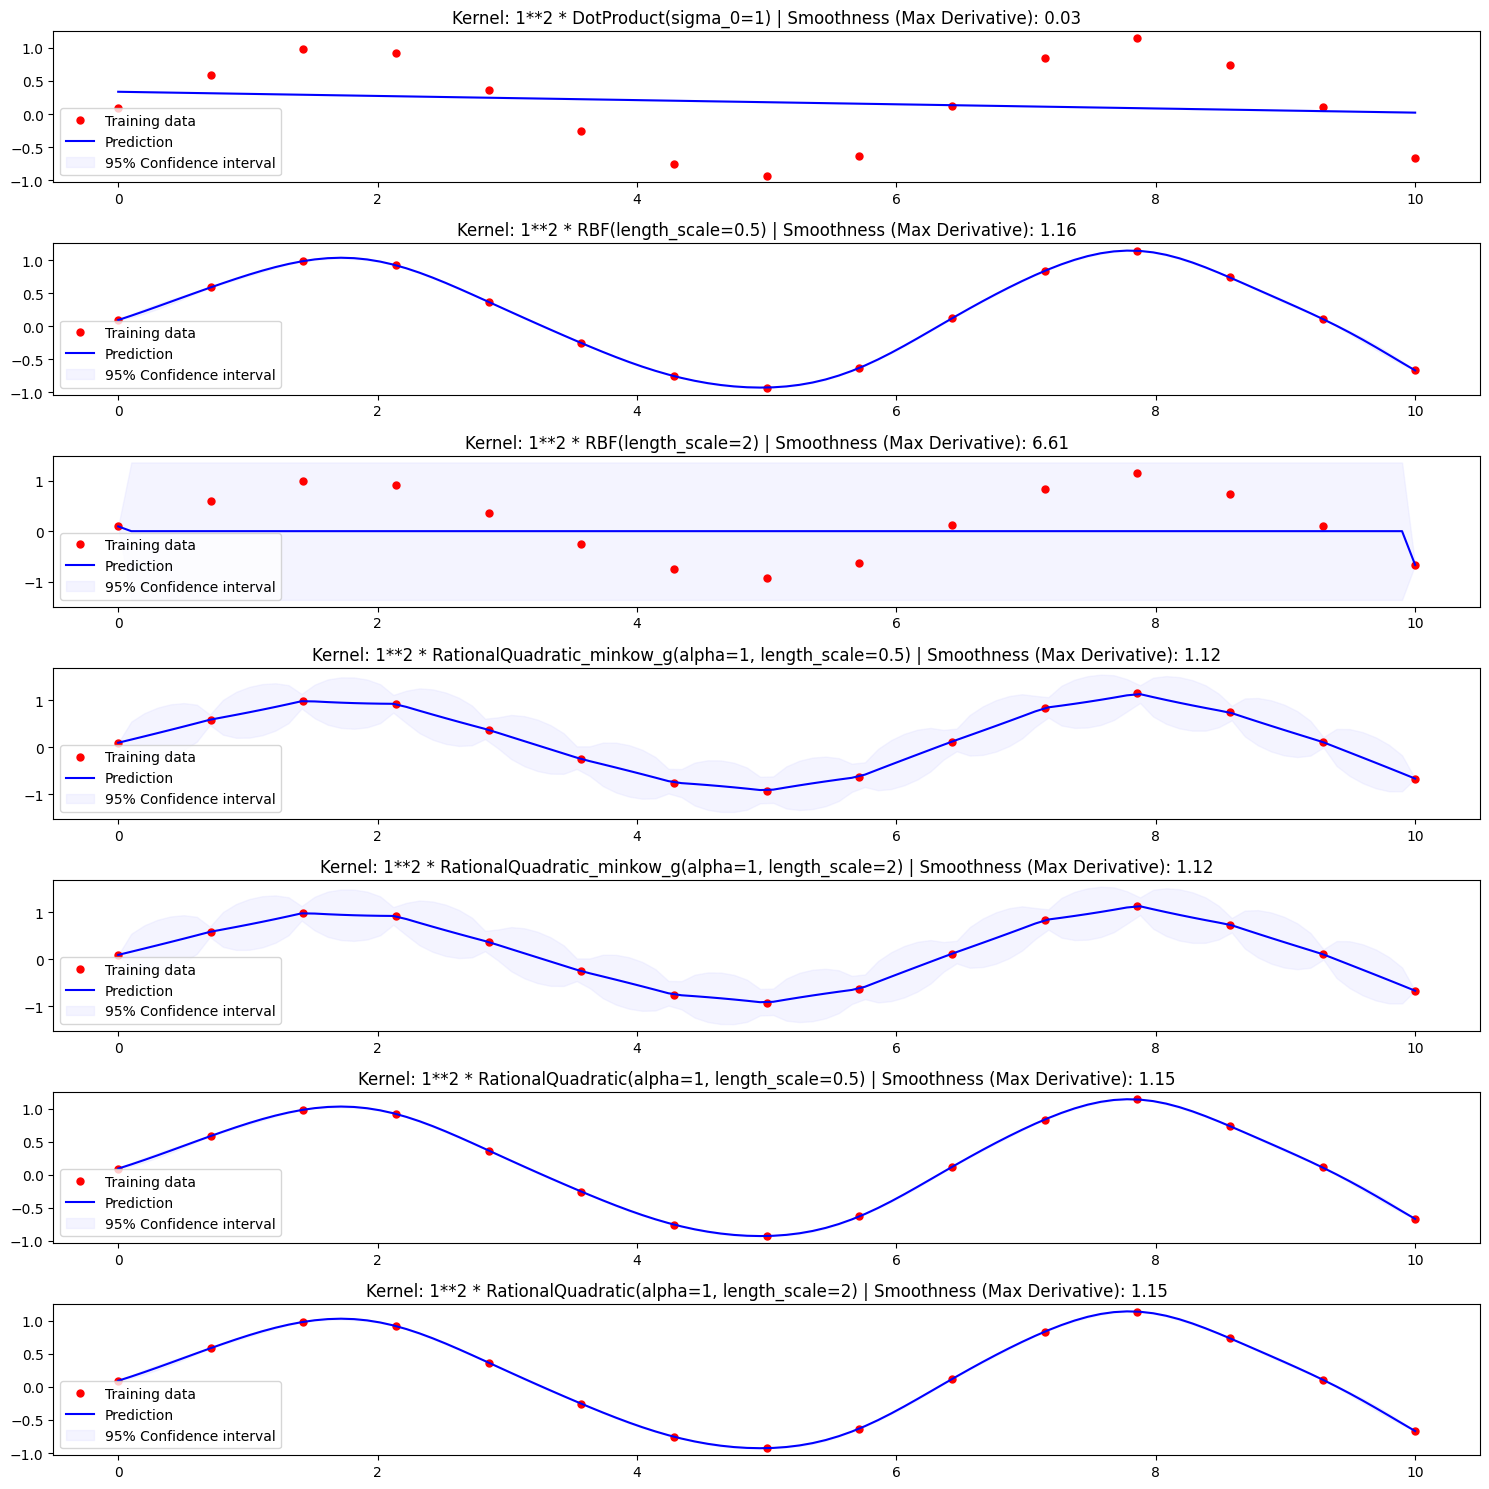

In [16]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ConstantKernel as C

# Create synthetic data
def f(x):
    return np.sin(x) + 0.1 * np.random.randn(*x.shape)

# Generate training data
X_train = np.linspace(0, 10, 15).reshape(-1, 1)
y_train = f(X_train)

# Create test data
X_test = np.linspace(0, 10, 100).reshape(-1, 1)

# List of kernels to test
kernels = [
    C(1.0) * DotProduct(),
    C(1.0) * RBF(length_scale=0.5),  # RBF Kernel (smooth)
    C(1.0) * RBF(length_scale=2.0),  # RBF Kernel (less smooth)
    #C(1.0) * Matern(length_scale=1.0, nu=1.5),  # Matern Kernel (smooth)
    #C(1.0) * Matern(length_scale=1.0, nu=0.5),  # Matern Kernel (less smooth)
    #C(1.0) * Matern(length_scale=2.0, nu=0.5),  # Matern Kernel
    C(1.0) * RationalQuadratic_minkow_g(length_scale=0.5,alpha=1) ,
    #C(1.0) * RationalQuadratic_minkow_g(length_scale=1,alpha=1) ,
    C(1.0) * RationalQuadratic_minkow_g(length_scale=2,alpha=1) ,
    #C(1.0) * RationalQuadratic_minkow_g(length_scale=5,alpha=1) ,
    C(1.0) * RationalQuadratic(length_scale=0.5, alpha=1.0), # Rational Quadratic Kernel
    C(1.0) * RationalQuadratic(length_scale=2.0, alpha=1.0), # Rational Quadratic Kernel
    #C(1.0) * RationalQuadratic(length_scale=5.0, alpha=1.0) 
]

plt.figure(figsize=(15, 15))

# Loop through each kernel
for i, kernel in enumerate(kernels):
    # Create Gaussian Process model
    gp = GaussianProcessRegressor(kernel=kernel)
    
    # Fit to training data
    gp.fit(X_train, y_train)
    
    # Make predictions
    y_pred, sigma = gp.predict(X_test, return_std=True)
    
    # Calculate the first derivative (smoothness)
    y_derivative = np.gradient(y_pred, X_test.ravel())
    
    # Plot the results
    plt.subplot(len(kernels), 1, i + 1)
    plt.plot(X_train, y_train, 'r.', markersize=10, label='Training data')
    plt.plot(X_test, y_pred, 'b-', label='Prediction')
    plt.fill_between(X_test.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma,
                     alpha=0.2, color='#CCCCFF', label='95% Confidence interval')
    plt.title(f'Kernel: {kernel} | Smoothness (Max Derivative): {np.max(np.abs(y_derivative)):.2f}')
    plt.legend()

plt.tight_layout()
plt.savefig('Gaussian_smoothness.eps')
plt.show()


In [27]:
X_test.shape

(100, 1)

Kernel: 1**2 * RBF(length_scale=0.5), Log Marginal Likelihood: -8.31
Kernel: 1**2 * RBF(length_scale=2), Log Marginal Likelihood: -15.51
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
Kernel: 1**2 * RationalQuadratic_minkow_g(alpha=1, length_scale=0.5), Log Marginal Likelihood: -10.48
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No Y input
No

/home/u/pgpt/privateGPT/pgpt/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/u/pgpt/privateGPT/pgpt/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/u/pgpt/privateGPT/pgpt/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


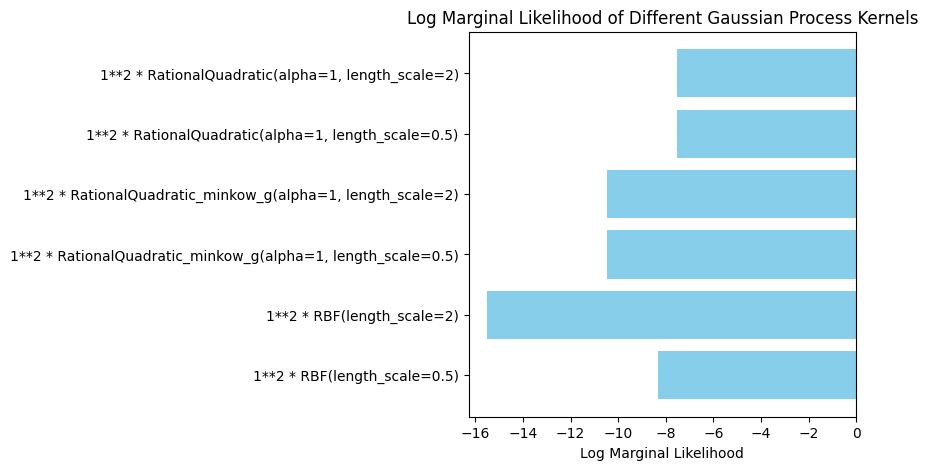

In [25]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ConstantKernel as C

# Create synthetic data
def f(x):
    return np.sin(x) + 0.1 * np.random.randn(*x.shape)

# Generate training data
X_train = np.linspace(0, 10, 15).reshape(-1, 1)
y_train = f(X_train)

# List of kernels to test
kernels = [
    #C(1.0) * DotProduct(),
    C(1.0) * RBF(length_scale=0.5),  # RBF Kernel (smooth)
    C(1.0) * RBF(length_scale=2.0),  # RBF Kernel (less smooth)
    #C(1.0) * Matern(length_scale=1.0, nu=1.5),  # Matern Kernel (smooth)
    #C(1.0) * Matern(length_scale=1.0, nu=0.5),  # Matern Kernel (less smooth)
    #C(1.0) * Matern(length_scale=2.0, nu=0.5),  # Matern Kernel
    C(1.0) * RationalQuadratic_minkow_g(length_scale=0.5,alpha=1) ,
    #C(1.0) * RationalQuadratic_minkow_g(length_scale=1,alpha=1) ,
    C(1.0) * RationalQuadratic_minkow_g(length_scale=2,alpha=1) ,
    #C(1.0) * RationalQuadratic_minkow_g(length_scale=5,alpha=1) ,
    C(1.0) * RationalQuadratic(length_scale=0.5, alpha=1.0), # Rati，onal Quadratic Kernel
    C(1.0) * RationalQuadratic(length_scale=2.0, alpha=1.0), # Rational Quadratic Kernel
    #C(1.0) * RationalQuadratic(length_scale=5.0, alpha=1.0) 
]
# Store log marginal likelihood for each kernel
log_marginal_likelihoods = []
plt.figure(figsize=(5,5))
# Loop through each kernel
for kernel in kernels:
    # Create Gaussian Process model
    gp = GaussianProcessRegressor(kernel=kernel)
    
    # Fit to training data
    gp.fit(X_train, y_train)
    
    # Calculate log marginal likelihood
    log_marginal_likelihood = gp.log_marginal_likelihood(gp.kernel_.theta)
    log_marginal_likelihoods.append(log_marginal_likelihood)
    print(f"Kernel: {kernel}, Log Marginal Likelihood: {log_marginal_likelihood:.2f}")

# Plot log marginal likelihoods
kernel_names = [str(kernel) for kernel in kernels]
plt.barh(kernel_names, log_marginal_likelihoods, color='skyblue')
plt.xlabel('Log Marginal Likelihood')
plt.title('Log Marginal Likelihood of Different Gaussian Process Kernels')
plt.savefig("gaussian_log_margin.eps")
plt.show()


In [26]:
X_train.shape

(15, 1)

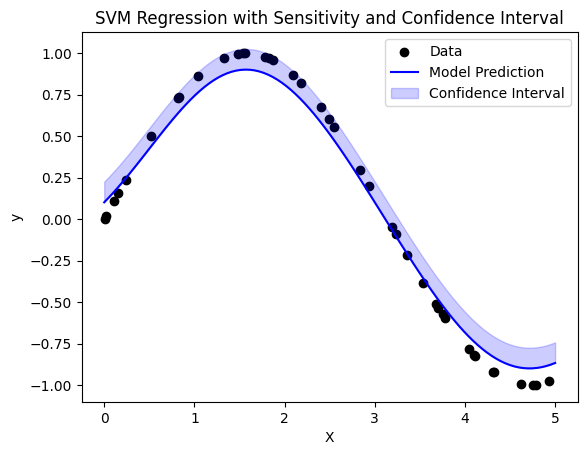

Sensitivity: -0.15171563564761345
Confidence Interval: [-0.12457869 -0.0021051 ]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error

# Sample data (replace with your own dataset)
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()

# Define parameter grid for GridSearchCV
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.3]
}

# Perform GridSearchCV to find optimal hyperparameters
grid_search = GridSearchCV(SVR(), param_grid, cv=5)
grid_search.fit(X, y)

# Get the best model
best_model = grid_search.best_estimator_

# Predict and calculate sensitivity
X_test = np.linspace(0, 5, 100)[:, np.newaxis]
y_pred = best_model.predict(X_test)

# Perturb input and calculate sensitivity
X_perturbed = X_test * 1.1
y_pred_perturbed = best_model.predict(X_perturbed)
sensitivity = np.mean(np.abs(y_pred_perturbed - y_pred) / y_pred)

# Calculate confidence intervals using cross-validation
scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
confidence_interval = np.percentile(scores, [2.5, 97.5])

# Plot the results
plt.figure()
plt.scatter(X, y, color='black', label='Data')
plt.plot(X_test, y_pred, color='blue', label='Model Prediction')
plt.fill_between(X_test.ravel(), y_pred - confidence_interval[1], y_pred - confidence_interval[0],
                 alpha=0.2, color='blue', label='Confidence Interval')
plt.xlabel('X')
plt.ylabel('y')
plt.title('SVM Regression with Sensitivity and Confidence Interval')
plt.legend()
plt.show()

print("Sensitivity:", sensitivity)
print("Confidence Interval:", confidence_interval)

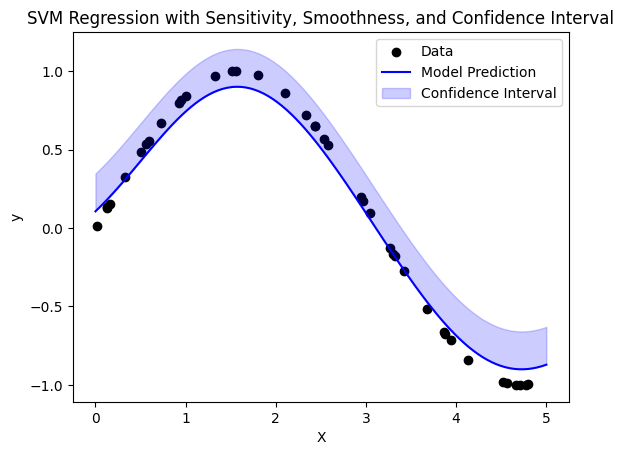

Sensitivity: -0.04296676678006442
Smoothness: 0.0008791291929812944
Confidence Interval: [-0.24121181 -0.00197447]


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error

# Sample data (replace with your own dataset)
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()

# Define parameter grid for GridSearchCV
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.3]
}

# Perform GridSearchCV to find optimal hyperparameters
grid_search = GridSearchCV(SVR(), param_grid, cv=5)
grid_search.fit(X, y)

# Get the best model
best_model = grid_search.best_estimator_

# Predict and calculate sensitivity, smoothness, and confidence interval
X_test = np.linspace(0, 5, 100)[:, np.newaxis]
y_pred = best_model.predict(X_test)

# Perturb input and calculate sensitivity
X_perturbed = X_test * 1.1
y_pred_perturbed = best_model.predict(X_perturbed)
sensitivity = np.mean(np.abs(y_pred_perturbed - y_pred) / y_pred)

# Calculate smoothness (mean squared difference between consecutive predicted values)
smoothness = np.mean(np.diff(y_pred)**2)

# Calculate confidence intervals using cross-validation
scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
confidence_interval = np.percentile(scores, [2.5, 97.5])

# Plot the results
plt.figure()
plt.scatter(X, y, color='black', label='Data')
plt.plot(X_test, y_pred, color='blue', label='Model Prediction')
plt.fill_between(X_test.ravel(), y_pred - confidence_interval[1], y_pred - confidence_interval[0],
                 alpha=0.2, color='blue', label='Confidence Interval')
plt.xlabel('X')
plt.ylabel('y')
plt.title('SVM Regression with Sensitivity, Smoothness, and Confidence Interval')
plt.legend()
plt.show()

print("Sensitivity:", sensitivity)
print("Smoothness:", smoothness)
print("Confidence Interval:", confidence_interval)

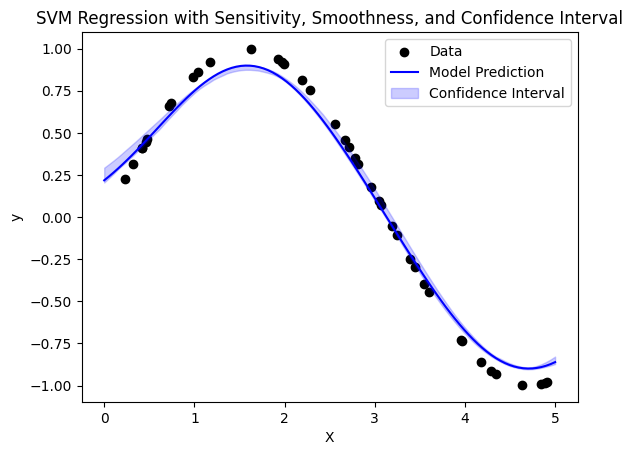

Sensitivity: 20.88245414054836
Smoothness: 0.0008114141160912929
Confidence Interval: [-0.23011593 -0.00109837]


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample

# Function to perform bootstrapping and calculate confidence intervals for SVR
def get_confidence_interval_svr(model, X_train, y_train, X_test, n_iterations=1000, ci=95):
    predictions = []
    # Bootstrapping
    for _ in range(n_iterations):
        # Resample the training data with replacement
        X_resampled, y_resampled = resample(X_train, y_train)
        model.fit(X_resampled, y_resampled)
        predictions.append(model.predict(X_test))
    
    predictions = np.array(predictions)
    # Calculate the lower and upper bounds of the confidence interval
    lower_bound = np.percentile(predictions, (100 - ci) / 2, axis=0)
    upper_bound = np.percentile(predictions, 100 - (100 - ci) / 2, axis=0)
    
    return lower_bound, upper_bound, predictions.mean(axis=0)

# Sample data (replace with your own dataset)
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()

# Define parameter grid for GridSearchCV
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2, 0.3]
}

# Perform GridSearchCV to find optimal hyperparameters
grid_search = GridSearchCV(SVR(), param_grid, cv=5)
grid_search.fit(X, y)

# Get the best model
best_model = grid_search.best_estimator_

# Predict and calculate sensitivity, smoothness, and confidence interval
X_test = np.linspace(0, 5, 100)[:, np.newaxis]
y_pred = best_model.predict(X_test)

# Perturb input and calculate sensitivity
X_perturbed = X_test * 1.1
y_pred_perturbed = best_model.predict(X_perturbed)
sensitivity = np.mean(np.abs(y_pred_perturbed - y_pred) / y_pred)

# Calculate smoothness (mean squared difference between consecutive predicted values)
smoothness = np.mean(np.diff(y_pred)**2)

# Calculate confidence intervals using cross-validation
#scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
#confidence_interval = np.percentile(scores, [2.5, 97.5])
lower_bound, upper_bound, mean_prediction = get_confidence_interval_svr(best_model, X, y, X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, color='black', label='Data')
plt.plot(X_test, y_pred, color='blue', label='Model Prediction')
plt.fill_between(X_test.ravel(), lower_bound, upper_bound, alpha=0.2, color='blue', label='Confidence Interval')
plt.xlabel('X')
plt.ylabel('y')
plt.title('SVM Regression with Sensitivity, Smoothness, and Confidence Interval')
plt.legend()
plt.show()

print("Sensitivity:", sensitivity)
print("Smoothness:", smoothness)
print("Confidence Interval:", confidence_interval)